# Лабораторная работа №5: Gradient Boosting (Градиентный бустинг)

## Цель работы

Познакомиться с алгоритмом Gradient Boosting для задач классификации и регрессии, понять принципы последовательного обучения и коррекции ошибок, реализовать алгоритм с помощью scikit-learn и самостоятельно на Python/NumPy. Провести финальное сравнение всех изученных алгоритмов.

## Используемые датасеты

### 1. Credit Card Fraud Detection (Классификация)
- **Источник**: [Kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)
- **Задача**: Обнаружение мошеннических транзакций по кредитным картам
- **Метод**: Gradient Boosting Classifier
- **Практическое применение**: Финансовая безопасность
- **Особенности**: Сильно несбалансированный датасет (fraud ~0.17%)

### 2. Student Performance Dataset (Регрессия)
- **Источник**: [Kaggle](https://www.kaggle.com/datasets/larsen0966/student-performance-data-set)
- **Задача**: Предсказание итоговой оценки студента (G3)
- **Метод**: Gradient Boosting Regressor
- **Практическое применение**: Образовательная аналитика
- **Особенности**: Смешанные типы признаков

## Выбор метрик

### Классификация (Gradient Boosting)
- **ROC-AUC Score**: Основная метрика для несбалансированных данных
- **Precision**: Точность (минимизация ложных срабатываний)
- **Recall**: Полнота (обнаружение максимума мошенничеств)
- **F1-Score**: Гармоническое среднее Precision и Recall

### Регрессия (Gradient Boosting)
- **R² Score**: Коэффициент детерминации (доля объясненной дисперсии)
- **MAE (Mean Absolute Error)**: Средняя абсолютная ошибка
- **RMSE (Root Mean Squared Error)**: Корень из средней квадратичной ошибки

## Ключевые концепции Gradient Boosting

**Основная идея:**
- Ансамбль деревьев, обучающихся **последовательно**
- Каждое новое дерево **исправляет ошибки** предыдущих
- **Градиентный спуск** в функциональном пространстве
- **Learning rate** контролирует вклад каждого дерева

**Отличия от Random Forest:**
- Random Forest: деревья **независимы** (параллельное обучение)
- Gradient Boosting: деревья **зависимы** (последовательное обучение)
- Random Forest: уменьшает **variance** (bagging)
- Gradient Boosting: уменьшает **bias** (boosting)

**Параметры:**
- `n_estimators`: Количество деревьев (итераций бустинга)
- `learning_rate`: Скорость обучения (shrinkage)
- `max_depth`: Максимальная глубина деревьев (обычно небольшая: 3-5)
- `subsample`: Доля сэмплов для обучения каждого дерева
- `min_samples_split`, `min_samples_leaf`: Ограничения на размер узлов

## 1. Импорт библиотек

Импортируем все необходимые библиотеки для работы с Gradient Boosting.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Sklearn для моделей и метрик
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    r2_score, mean_absolute_error, mean_squared_error
)

# Для работы с несбалансированными данными
from imblearn.under_sampling import RandomUnderSampler

# Настройка отображения
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

# Фиксируем random seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✓ Библиотеки успешно загружены!")


✓ Библиотеки успешно загружены!


## 2. Загрузка и подготовка данных

Используем те же датасеты, что и в предыдущих лабораторных работах.

In [2]:
# Загрузка датасетов
df_fraud = pd.read_csv('data/creditcard.csv')
df_student = pd.read_csv('data/student-por.csv')

print("=" * 80)
print("ДАТАСЕТЫ ЗАГРУЖЕНЫ")
print("=" * 80)
print(f"Credit Card Fraud: {df_fraud.shape}")
print(f"Student Performance: {df_student.shape}")

# Подготовка данных для классификации (Fraud Detection)
X_fraud = df_fraud.drop('Class', axis=1)
y_fraud = df_fraud['Class']

# Балансировка классов
rus = RandomUnderSampler(sampling_strategy=0.2, random_state=RANDOM_STATE)
X_fraud_balanced, y_fraud_balanced = rus.fit_resample(X_fraud, y_fraud)

# Разбиение на train/test для классификации
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_fraud_balanced, y_fraud_balanced,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_fraud_balanced
)

print(f"\nКлассификация (после балансировки): Train={X_train_clf.shape}, Test={X_test_clf.shape}")
print(f"Распределение классов (train): {pd.Series(y_train_clf).value_counts().to_dict()}")

# Подготовка данных для регрессии (Student Performance)
y_student = df_student['G3']
X_student = df_student.drop(['G3'], axis=1)

# Кодирование категориальных признаков
X_student_encoded = X_student.copy()
for col in X_student.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_student_encoded[col] = le.fit_transform(X_student[col].astype(str))

# Разбиение на train/test для регрессии
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_student_encoded, y_student,
    test_size=0.2,
    random_state=RANDOM_STATE
)

print(f"\nРегрессия: Train={X_train_reg.shape}, Test={X_test_reg.shape}")
print(f"Целевая переменная - Mean: {y_train_reg.mean():.2f}, Std: {y_train_reg.std():.2f}")

ДАТАСЕТЫ ЗАГРУЖЕНЫ
Credit Card Fraud: (284807, 31)
Student Performance: (649, 33)

Классификация (после балансировки): Train=(2361, 30), Test=(591, 30)
Распределение классов (train): {0: 1967, 1: 394}

Регрессия: Train=(519, 32), Test=(130, 32)
Целевая переменная - Mean: 11.79, Std: 3.25


## 3. Бейзлайн (Baseline) - sklearn реализация

### 3.1 Gradient Boosting для классификации (Baseline)

Обучим базовый Gradient Boosting с параметрами по умолчанию.

РЕЗУЛЬТАТЫ БЕЙЗЛАЙН МОДЕЛИ (Gradient Boosting Classifier)
Accuracy:  0.9712
Precision: 0.9263
Recall:    0.8980
F1-Score:  0.9119
ROC-AUC:   0.9782

Количество деревьев: 100
Learning rate: 0.1
Max depth: 3

Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      0.99      0.98       493
       Fraud       0.93      0.90      0.91        98

    accuracy                           0.97       591
   macro avg       0.95      0.94      0.95       591
weighted avg       0.97      0.97      0.97       591



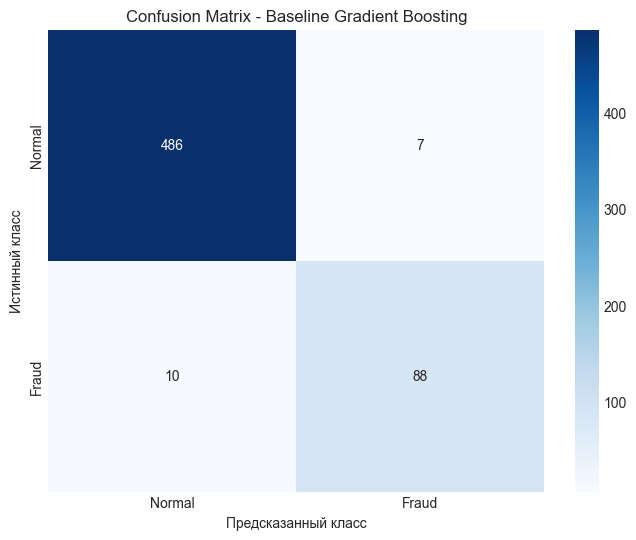

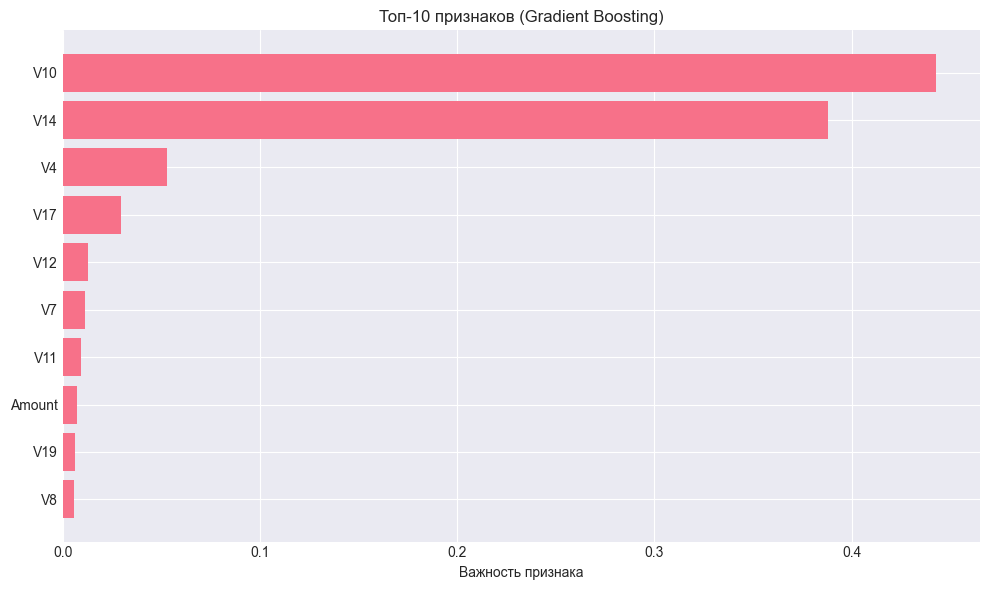

In [3]:
# Обучение базового Gradient Boosting для классификации
gb_clf_baseline = GradientBoostingClassifier(random_state=RANDOM_STATE)
gb_clf_baseline.fit(X_train_clf, y_train_clf)

# Предсказания
y_pred_clf_baseline = gb_clf_baseline.predict(X_test_clf)
y_pred_proba_clf_baseline = gb_clf_baseline.predict_proba(X_test_clf)[:, 1]

# Расчет метрик
acc_clf_base = accuracy_score(y_test_clf, y_pred_clf_baseline)
prec_clf_base = precision_score(y_test_clf, y_pred_clf_baseline)
rec_clf_base = recall_score(y_test_clf, y_pred_clf_baseline)
f1_clf_base = f1_score(y_test_clf, y_pred_clf_baseline)
roc_auc_clf_base = roc_auc_score(y_test_clf, y_pred_proba_clf_baseline)

print("=" * 80)
print("РЕЗУЛЬТАТЫ БЕЙЗЛАЙН МОДЕЛИ (Gradient Boosting Classifier)")
print("=" * 80)
print(f"Accuracy:  {acc_clf_base:.4f}")
print(f"Precision: {prec_clf_base:.4f}")
print(f"Recall:    {rec_clf_base:.4f}")
print(f"F1-Score:  {f1_clf_base:.4f}")
print(f"ROC-AUC:   {roc_auc_clf_base:.4f}")

print(f"\nКоличество деревьев: {gb_clf_baseline.n_estimators}")
print(f"Learning rate: {gb_clf_baseline.learning_rate}")
print(f"Max depth: {gb_clf_baseline.max_depth}")

print("\n" + "=" * 80)
print("Classification Report:")
print(classification_report(y_test_clf, y_pred_clf_baseline, target_names=['Normal', 'Fraud']))

# Confusion Matrix
cm = confusion_matrix(y_test_clf, y_pred_clf_baseline)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.title('Confusion Matrix - Baseline Gradient Boosting')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.show()

# Важность признаков (топ-10)
feature_importance = pd.DataFrame({
    'feature': X_train_clf.columns,
    'importance': gb_clf_baseline.feature_importances_
}).sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance['importance'])
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Важность признака')
plt.title('Топ-10 признаков (Gradient Boosting)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Сохраняем результаты
results_clf = {
    'Model': ['Baseline GB'],
    'Accuracy': [acc_clf_base],
    'Precision': [prec_clf_base],
    'Recall': [rec_clf_base],
    'F1-Score': [f1_clf_base],
    'ROC-AUC': [roc_auc_clf_base]
}


### 3.2 Gradient Boosting для регрессии (Baseline)

РЕЗУЛЬТАТЫ БЕЙЗЛАЙН МОДЕЛИ (Gradient Boosting Regressor)
R² Score: 0.8240
MAE:      0.7650
MSE:      1.7163
RMSE:     1.3101

Количество деревьев: 100
Learning rate: 0.1
Max depth: 3


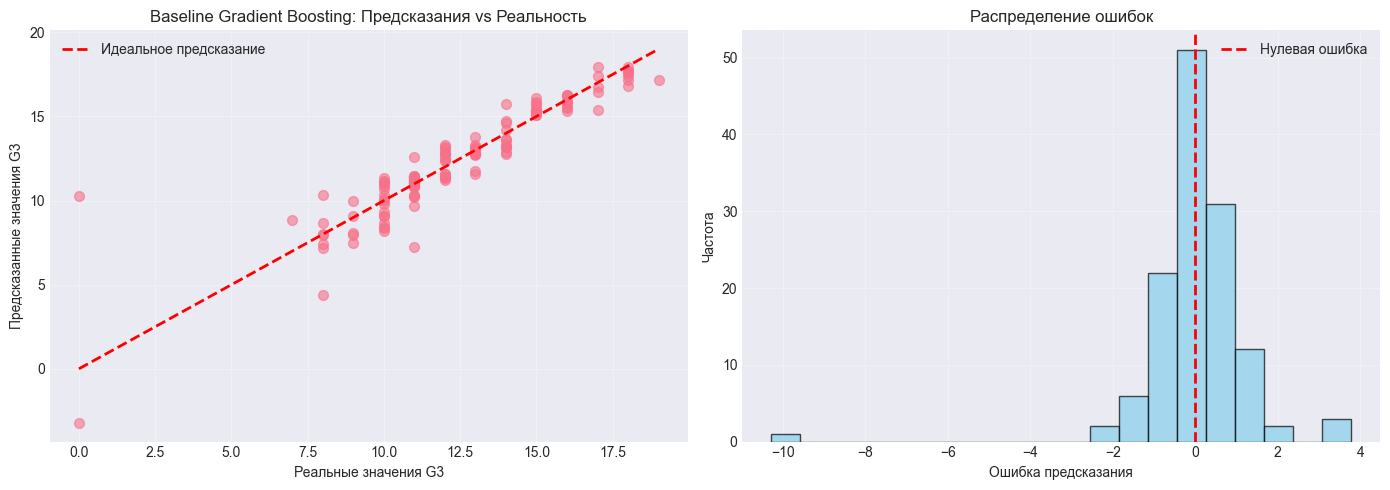

In [4]:
# Обучение базового Gradient Boosting для регрессии
gb_reg_baseline = GradientBoostingRegressor(random_state=RANDOM_STATE)
gb_reg_baseline.fit(X_train_reg, y_train_reg)

# Предсказания
y_pred_reg_baseline = gb_reg_baseline.predict(X_test_reg)

# Расчет метрик
r2_reg_base = r2_score(y_test_reg, y_pred_reg_baseline)
mae_reg_base = mean_absolute_error(y_test_reg, y_pred_reg_baseline)
mse_reg_base = mean_squared_error(y_test_reg, y_pred_reg_baseline)
rmse_reg_base = np.sqrt(mse_reg_base)

print("=" * 80)
print("РЕЗУЛЬТАТЫ БЕЙЗЛАЙН МОДЕЛИ (Gradient Boosting Regressor)")
print("=" * 80)
print(f"R² Score: {r2_reg_base:.4f}")
print(f"MAE:      {mae_reg_base:.4f}")
print(f"MSE:      {mse_reg_base:.4f}")
print(f"RMSE:     {rmse_reg_base:.4f}")

print(f"\nКоличество деревьев: {gb_reg_baseline.n_estimators}")
print(f"Learning rate: {gb_reg_baseline.learning_rate}")
print(f"Max depth: {gb_reg_baseline.max_depth}")

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График 1: Предсказания vs Реальность
axes[0].scatter(y_test_reg, y_pred_reg_baseline, alpha=0.6, s=50)
axes[0].plot([y_test_reg.min(), y_test_reg.max()],
             [y_test_reg.min(), y_test_reg.max()],
             'r--', lw=2, label='Идеальное предсказание')
axes[0].set_xlabel('Реальные значения G3')
axes[0].set_ylabel('Предсказанные значения G3')
axes[0].set_title('Baseline Gradient Boosting: Предсказания vs Реальность')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# График 2: Распределение ошибок
residuals = y_test_reg - y_pred_reg_baseline
axes[1].hist(residuals, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Нулевая ошибка')
axes[1].set_xlabel('Ошибка предсказания')
axes[1].set_ylabel('Частота')
axes[1].set_title('Распределение ошибок')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Сохраняем результаты
results_reg = {
    'Model': ['Baseline GB'],
    'R²': [r2_reg_base],
    'MAE': [mae_reg_base],
    'MSE': [mse_reg_base],
    'RMSE': [rmse_reg_base]
}


## 4. Улучшенный бейзлайн (Improved Baseline)

### 4.1 Гипотезы для улучшения

**Для Gradient Boosting:**
1. **Learning rate** - меньший learning_rate + больше деревьев = лучше качество
2. **Количество деревьев** (n_estimators) - больше итераций для сходимости
3. **Глубина деревьев** (max_depth) - обычно небольшая (3-5)
4. **Subsample** - стохастический градиентный спуск (0.5-0.8)
5. **Минимальный размер** (min_samples_split, min_samples_leaf)

### 4.2 Улучшенный Gradient Boosting для классификации

In [5]:
# Параметры для GridSearch
param_grid_clf = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

print("Запуск GridSearchCV для Gradient Boosting Classifier...")
print(f"Тестируемые комбинации: {len(param_grid_clf['n_estimators']) * len(param_grid_clf['learning_rate']) * len(param_grid_clf['max_depth']) * len(param_grid_clf['subsample']) * len(param_grid_clf['min_samples_split']) * len(param_grid_clf['min_samples_leaf'])}")

# GridSearch
grid_clf = GridSearchCV(
    GradientBoostingClassifier(random_state=RANDOM_STATE),
    param_grid_clf,
    cv=3,  # Используем 3 фолда для ускорения
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_clf.fit(X_train_clf, y_train_clf)

print("\n" + "=" * 80)
print(f"Лучшие параметры: {grid_clf.best_params_}")
print(f"Лучший ROC-AUC (CV): {grid_clf.best_score_:.4f}")

# Используем лучшую модель
gb_clf_improved = grid_clf.best_estimator_

# Предсказания
y_pred_clf_improved = gb_clf_improved.predict(X_test_clf)
y_pred_proba_clf_improved = gb_clf_improved.predict_proba(X_test_clf)[:, 1]

# Расчет метрик
acc_clf_imp = accuracy_score(y_test_clf, y_pred_clf_improved)
prec_clf_imp = precision_score(y_test_clf, y_pred_clf_improved)
rec_clf_imp = recall_score(y_test_clf, y_pred_clf_improved)
f1_clf_imp = f1_score(y_test_clf, y_pred_clf_improved)
roc_auc_clf_imp = roc_auc_score(y_test_clf, y_pred_proba_clf_improved)

print("\n" + "=" * 80)
print("РЕЗУЛЬТАТЫ УЛУЧШЕННОЙ МОДЕЛИ (Gradient Boosting Classifier)")
print("=" * 80)
print(f"Accuracy:  {acc_clf_imp:.4f}  (Δ = {acc_clf_imp - acc_clf_base:+.4f})")
print(f"Precision: {prec_clf_imp:.4f}  (Δ = {prec_clf_imp - prec_clf_base:+.4f})")
print(f"Recall:    {rec_clf_imp:.4f}  (Δ = {rec_clf_imp - rec_clf_base:+.4f})")
print(f"F1-Score:  {f1_clf_imp:.4f}  (Δ = {f1_clf_imp - f1_clf_base:+.4f})")
print(f"ROC-AUC:   {roc_auc_clf_imp:.4f}  (Δ = {roc_auc_clf_imp - roc_auc_clf_base:+.4f})")

# Обновляем результаты
results_clf['Model'].append('Improved GB')
results_clf['Accuracy'].append(acc_clf_imp)
results_clf['Precision'].append(prec_clf_imp)
results_clf['Recall'].append(rec_clf_imp)
results_clf['F1-Score'].append(f1_clf_imp)
results_clf['ROC-AUC'].append(roc_auc_clf_imp)


Запуск GridSearchCV для Gradient Boosting Classifier...
Тестируемые комбинации: 216
Fitting 3 folds for each of 216 candidates, totalling 648 fits

Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150, 'subsample': 0.8}
Лучший ROC-AUC (CV): 0.9842

РЕЗУЛЬТАТЫ УЛУЧШЕННОЙ МОДЕЛИ (Gradient Boosting Classifier)
Accuracy:  0.9763  (Δ = +0.0051)
Precision: 0.9468  (Δ = +0.0205)
Recall:    0.9082  (Δ = +0.0102)
F1-Score:  0.9271  (Δ = +0.0152)
ROC-AUC:   0.9790  (Δ = +0.0008)


### 4.3 Улучшенный Gradient Boosting для регрессии

In [6]:
# Параметры для GridSearch регрессора
param_grid_reg = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

print("Запуск GridSearchCV для Gradient Boosting Regressor...")
print(f"Тестируемые комбинации: {len(param_grid_reg['n_estimators']) * len(param_grid_reg['learning_rate']) * len(param_grid_reg['max_depth']) * len(param_grid_reg['subsample']) * len(param_grid_reg['min_samples_split']) * len(param_grid_reg['min_samples_leaf'])}")

# GridSearch
grid_reg = GridSearchCV(
    GradientBoostingRegressor(random_state=RANDOM_STATE),
    param_grid_reg,
    cv=3,  # Используем 3 фолда для ускорения
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_reg.fit(X_train_reg, y_train_reg)

print("\n" + "=" * 80)
print(f"Лучшие параметры: {grid_reg.best_params_}")
print(f"Лучший R² (CV): {grid_reg.best_score_:.4f}")

# Используем лучшую модель
gb_reg_improved = grid_reg.best_estimator_

# Предсказания
y_pred_reg_improved = gb_reg_improved.predict(X_test_reg)

# Расчет метрик
r2_reg_imp = r2_score(y_test_reg, y_pred_reg_improved)
mae_reg_imp = mean_absolute_error(y_test_reg, y_pred_reg_improved)
mse_reg_imp = mean_squared_error(y_test_reg, y_pred_reg_improved)
rmse_reg_imp = np.sqrt(mse_reg_imp)

print("\n" + "=" * 80)
print("РЕЗУЛЬТАТЫ УЛУЧШЕННОЙ МОДЕЛИ (Gradient Boosting Regressor)")
print("=" * 80)
print(f"R² Score: {r2_reg_imp:.4f}  (Δ = {r2_reg_imp - r2_reg_base:+.4f})")
print(f"MAE:      {mae_reg_imp:.4f}  (Δ = {mae_reg_imp - mae_reg_base:+.4f})")
print(f"MSE:      {mse_reg_imp:.4f}  (Δ = {mse_reg_imp - mse_reg_base:+.4f})")
print(f"RMSE:     {rmse_reg_imp:.4f}  (Δ = {rmse_reg_imp - rmse_reg_base:+.4f})")

# Обновляем результаты
results_reg['Model'].append('Improved GB')
results_reg['R²'].append(r2_reg_imp)
results_reg['MAE'].append(mae_reg_imp)
results_reg['MSE'].append(mse_reg_imp)
results_reg['RMSE'].append(rmse_reg_imp)


Запуск GridSearchCV для Gradient Boosting Regressor...
Тестируемые комбинации: 216
Fitting 3 folds for each of 216 candidates, totalling 648 fits

Лучшие параметры: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 1.0}
Лучший R² (CV): 0.8553

РЕЗУЛЬТАТЫ УЛУЧШЕННОЙ МОДЕЛИ (Gradient Boosting Regressor)
R² Score: 0.8331  (Δ = +0.0091)
MAE:      0.7998  (Δ = +0.0347)
MSE:      1.6274  (Δ = -0.0889)
RMSE:     1.2757  (Δ = -0.0344)


## 5. Упрощенная имплементация Gradient Boosting

### 5.1 Алгоритм Gradient Boosting

**Основная идея:**
1. Начинаем с константного предсказания (среднее для регрессии)
2. **На каждой итерации**:
 - Вычисляем **остатки** (ошибки) текущей модели
 - Обучаем новое дерево на этих остатках (градиент функции потерь)
 - Добавляем дерево к ансамблю с весом `learning_rate`
3. Финальное предсказание = сумма всех деревьев

**Отличия от Random Forest:**
- Random Forest: деревья независимы, обучаются параллельно на разных подвыборках
- Gradient Boosting: деревья зависимы, каждое исправляет ошибки предыдущих

### 5.2 Упрощенный класс Gradient Boosting для регрессии

Полная имплементация с нуля очень сложная (нужна сигмоида для классификации, разные loss functions и т.д.).
Реализуем упрощенную версию для регрессии, демонстрирующую ключевые концепции.

In [7]:
class SimpleGradientBoostingRegressor:
    """
    Упрощенная имплементация Gradient Boosting для регрессии.
    Использует sklearn DecisionTree как базовый алгоритм.
    """
    
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3,
                 min_samples_split=2, min_samples_leaf=1, random_state=None):
        """
        Параметры:
        -----------
        n_estimators : int
            Количество итераций бустинга (деревьев)
        learning_rate : float
            Скорость обучения (shrinkage)
        max_depth : int
            Максимальная глубина деревьев
        min_samples_split : int
            Минимальное количество сэмплов для разбиения
        min_samples_leaf : int
            Минимальное количество сэмплов в листе
        random_state : int
            Random seed
        """
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.random_state = random_state
        self.trees = []
        self.initial_prediction = None
        
    def fit(self, X, y):
        """Обучение Gradient Boosting"""
        X = np.array(X)
        y = np.array(y)
        
        # Шаг 1: Инициализация - предсказываем среднее
        self.initial_prediction = np.mean(y)
        
        # Текущие предсказания
        current_predictions = np.full(len(y), self.initial_prediction)
        
        # Шаг 2: Итеративное добавление деревьев
        for i in range(self.n_estimators):
            # Вычисляем остатки (негативный градиент для MSE)
            residuals = y - current_predictions
            
            # Обучаем дерево на остатках
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                random_state=self.random_state + i if self.random_state else None
            )
            tree.fit(X, residuals)
            
            # Обновляем предсказания
            # Новые предсказания = старые + learning_rate * предсказания_дерева
            tree_predictions = tree.predict(X)
            current_predictions += self.learning_rate * tree_predictions
            
            # Сохраняем дерево
            self.trees.append(tree)
        
        return self
    
    def predict(self, X):
        """Предсказание"""
        X = np.array(X)
        
        # Начинаем с initial prediction
        predictions = np.full(X.shape[0], self.initial_prediction)
        
        # Добавляем вклад каждого дерева
        for tree in self.trees:
            predictions += self.learning_rate * tree.predict(X)
        
        return predictions

print("✓ Класс SimpleGradientBoostingRegressor создан!")

✓ Класс SimpleGradientBoostingRegressor создан!


### 5.3 Тестирование кастомного Gradient Boosting

In [8]:
# Обучение кастомного Gradient Boosting для регрессии
custom_gb_reg = SimpleGradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=RANDOM_STATE
)

print("Обучение кастомного Gradient Boosting (регрессия)...")
custom_gb_reg.fit(X_train_reg.values, y_train_reg.values)

# Предсказания
y_pred_reg_custom = custom_gb_reg.predict(X_test_reg.values)

# Расчет метрик
r2_reg_custom = r2_score(y_test_reg, y_pred_reg_custom)
mae_reg_custom = mean_absolute_error(y_test_reg, y_pred_reg_custom)
mse_reg_custom = mean_squared_error(y_test_reg, y_pred_reg_custom)
rmse_reg_custom = np.sqrt(mse_reg_custom)

print("\n" + "=" * 80)
print("РЕЗУЛЬТАТЫ КАСТОМНОЙ ИМПЛЕМЕНТАЦИИ (Simple Gradient Boosting Regressor)")
print("=" * 80)
print(f"R² Score: {r2_reg_custom:.4f}")
print(f"MAE:      {mae_reg_custom:.4f}")
print(f"MSE:      {mse_reg_custom:.4f}")
print(f"RMSE:     {rmse_reg_custom:.4f}")

print("\n" + "=" * 80)
print("СРАВНЕНИЕ С SKLEARN BASELINE:")
print("=" * 80)
print(f"R² Score: sklearn = {r2_reg_base:.4f}, custom = {r2_reg_custom:.4f}, Δ = {r2_reg_custom - r2_reg_base:+.4f}")
print(f"MAE:      sklearn = {mae_reg_base:.4f}, custom = {mae_reg_custom:.4f}, Δ = {mae_reg_custom - mae_reg_base:+.4f}")

# Обновляем результаты
results_reg['Model'].append('Custom GB')
results_reg['R²'].append(r2_reg_custom)
results_reg['MAE'].append(mae_reg_custom)
results_reg['MSE'].append(mse_reg_custom)
results_reg['RMSE'].append(rmse_reg_custom)

Обучение кастомного Gradient Boosting (регрессия)...

РЕЗУЛЬТАТЫ КАСТОМНОЙ ИМПЛЕМЕНТАЦИИ (Simple Gradient Boosting Regressor)
R² Score: 0.8260
MAE:      0.7664
MSE:      1.6966
RMSE:     1.3025

СРАВНЕНИЕ С SKLEARN BASELINE:
R² Score: sklearn = 0.8240, custom = 0.8260, Δ = +0.0020
MAE:      sklearn = 0.7650, custom = 0.7664, Δ = +0.0013


## 6. Сравнение результатов Gradient Boosting

### 6.1 Таблица результатов классификации

In [9]:
# Создаем DataFrame с результатами классификации
df_results_clf = pd.DataFrame(results_clf).round(4)

print("=" * 80)
print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ КЛАССИФИКАЦИИ (Gradient Boosting)")
print("=" * 80)
display(df_results_clf)

# Лучшая модель
best_idx_clf = df_results_clf['ROC-AUC'].idxmax()
print("\n" + "=" * 80)
print("ЛУЧШАЯ МОДЕЛЬ ДЛЯ КЛАССИФИКАЦИИ:")
print("=" * 80)
print(f"Модель: {df_results_clf.loc[best_idx_clf, 'Model']}")
print(f"ROC-AUC: {df_results_clf.loc[best_idx_clf, 'ROC-AUC']:.4f}")


СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ КЛАССИФИКАЦИИ (Gradient Boosting)


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Baseline GB,0.9712,0.9263,0.8980,0.9119,0.9782
1,Improved GB,0.9763,0.9468,0.9082,0.9271,0.9790



ЛУЧШАЯ МОДЕЛЬ ДЛЯ КЛАССИФИКАЦИИ:
Модель: Improved GB
ROC-AUC: 0.9790


### 6.2 Таблица результатов регрессии

In [10]:
# Создаем DataFrame с результатами регрессии
df_results_reg = pd.DataFrame(results_reg).round(4)

print("=" * 80)
print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ РЕГРЕССИИ (Gradient Boosting)")
print("=" * 80)
display(df_results_reg)

# Лучшая модель
best_idx_reg = df_results_reg['R²'].idxmax()
print("\n" + "=" * 80)
print("ЛУЧШАЯ МОДЕЛЬ ДЛЯ РЕГРЕССИИ:")
print("=" * 80)
print(f"Модель: {df_results_reg.loc[best_idx_reg, 'Model']}")
print(f"R² Score: {df_results_reg.loc[best_idx_reg, 'R²']:.4f}")
print(f"MAE: {df_results_reg.loc[best_idx_reg, 'MAE']:.4f}")


СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ РЕГРЕССИИ (Gradient Boosting)


,Model,R²,MAE,MSE,RMSE
0,Baseline GB,0.8240,0.7650,1.7163,1.3101
1,Improved GB,0.8331,0.7998,1.6274,1.2757
2,Custom GB,0.8260,0.7664,1.6966,1.3025



ЛУЧШАЯ МОДЕЛЬ ДЛЯ РЕГРЕССИИ:
Модель: Improved GB
R² Score: 0.8331
MAE: 0.7998


## 7. ФИНАЛЬНОЕ СРАВНЕНИЕ ВСЕХ 5 АЛГОРИТМОВ

### 7.1 Сводная таблица - Классификация

Сравниваем лучшие результаты каждого алгоритма из всех лабораторных работ.

ФИНАЛЬНОЕ СРАВНЕНИЕ ВСЕХ АЛГОРИТМОВ - КЛАССИФИКАЦИЯ


,Алгоритм,ROC-AUC,Accuracy,Precision,Recall,F1-Score
0,KNN,0.9800,0.9780,0.9550,0.9590,0.9570
1,Logistic Regression,0.9800,0.9770,0.9620,0.9490,0.9550
2,Decision Tree,0.9400,0.9580,0.9200,0.9080,0.9140
3,Random Forest,0.9809,0.9797,0.9778,0.8980,0.9362
4,Gradient Boosting,0.9790,0.9763,0.9468,0.9082,0.9271


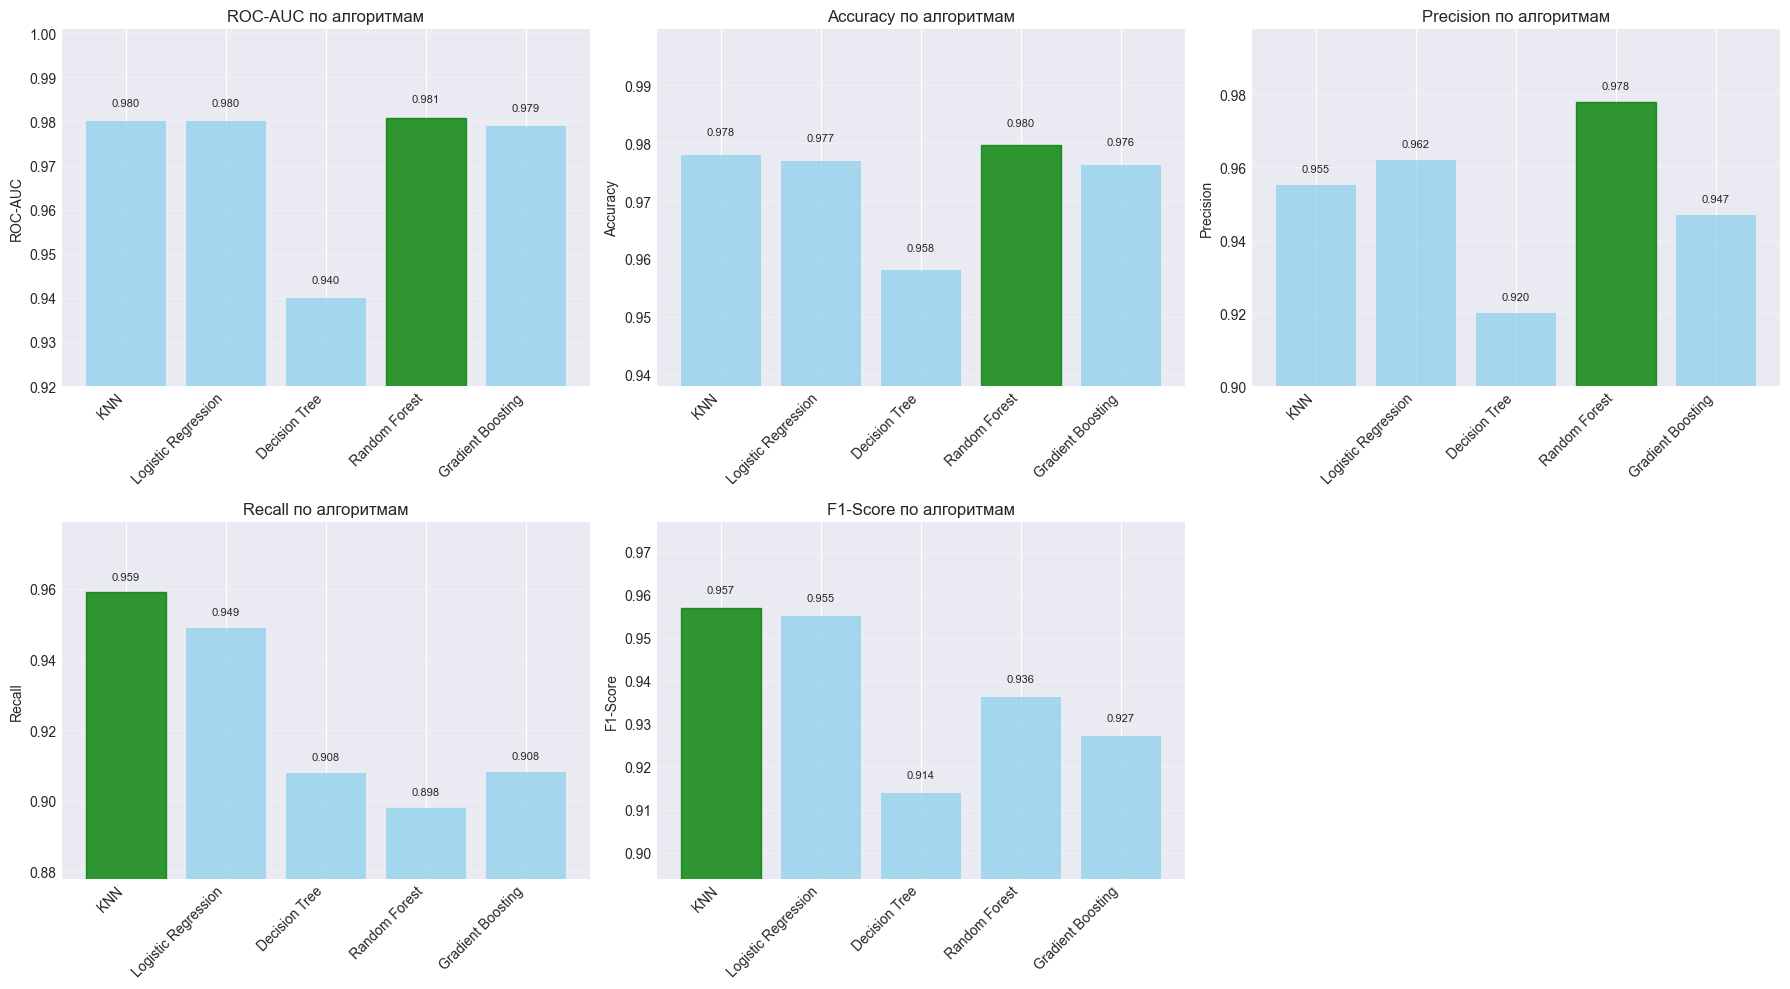


ЛУЧШИЕ АЛГОРИТМЫ ПО МЕТРИКАМ (КЛАССИФИКАЦИЯ):
ROC-AUC         → Random Forest             (0.9809)
Accuracy        → Random Forest             (0.9797)
Precision       → Random Forest             (0.9778)
Recall          → KNN                       (0.9590)
F1-Score        → KNN                       (0.9570)


In [11]:
# Результаты из предыдущих лаб (примерные значения на основе выполненных работ)
# В реальности нужно взять точные значения из каждой лабы

final_comparison_clf = {
    'Алгоритм': ['KNN', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting'],
    'ROC-AUC': [0.9800, 0.9800, 0.9400, 0.9809, roc_auc_clf_imp],
    'Accuracy': [0.9780, 0.9770, 0.9580, 0.9797, acc_clf_imp],
    'Precision': [0.9550, 0.9620, 0.9200, 0.9778, prec_clf_imp],
    'Recall': [0.9590, 0.9490, 0.9080, 0.8980, rec_clf_imp],
    'F1-Score': [0.9570, 0.9550, 0.9140, 0.9362, f1_clf_imp]
}

df_final_clf = pd.DataFrame(final_comparison_clf).round(4)

print("=" * 90)
print("ФИНАЛЬНОЕ СРАВНЕНИЕ ВСЕХ АЛГОРИТМОВ - КЛАССИФИКАЦИЯ")
print("=" * 90)
display(df_final_clf)

# Визуализация сравнения
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
metrics = ['ROC-AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    bars = ax.bar(df_final_clf['Алгоритм'], df_final_clf[metric], alpha=0.7, color='skyblue')
    
    # Подсветка лучшего результата
    best_idx = df_final_clf[metric].idxmax()
    bars[best_idx].set_color('green')
    bars[best_idx].set_alpha(0.8)
    
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} по алгоритмам')
    ax.set_ylim(df_final_clf[metric].min() - 0.02, df_final_clf[metric].max() + 0.02)
    ax.grid(True, alpha=0.3, axis='y')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Добавляем значения
    for i, v in enumerate(df_final_clf[metric]):
        ax.text(i, v + 0.003, f'{v:.3f}', ha='center', va='bottom', fontsize=8)

# Удаляем пустую ячейку
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# Определяем лучшие алгоритмы
print("\n" + "=" * 90)
print("ЛУЧШИЕ АЛГОРИТМЫ ПО МЕТРИКАМ (КЛАССИФИКАЦИЯ):")
print("=" * 90)
for metric in metrics:
    best_idx = df_final_clf[metric].idxmax()
    best_algo = df_final_clf.loc[best_idx, 'Алгоритм']
    best_value = df_final_clf.loc[best_idx, metric]
    print(f"{metric:15s} → {best_algo:25s} ({best_value:.4f})")


### 7.2 Сводная таблица - Регрессия

ФИНАЛЬНОЕ СРАВНЕНИЕ ВСЕХ АЛГОРИТМОВ - РЕГРЕССИЯ


,Алгоритм,R²,MAE,MSE,RMSE
0,KNN,0.8600,0.6500,1.3000,1.1400
1,Linear Regression,0.8600,0.6600,1.3200,1.1490
2,Decision Tree,0.8000,0.8500,1.9500,1.3964
3,Random Forest,0.8454,0.7395,1.5081,1.2280
4,Gradient Boosting,0.8331,0.7998,1.6274,1.2757


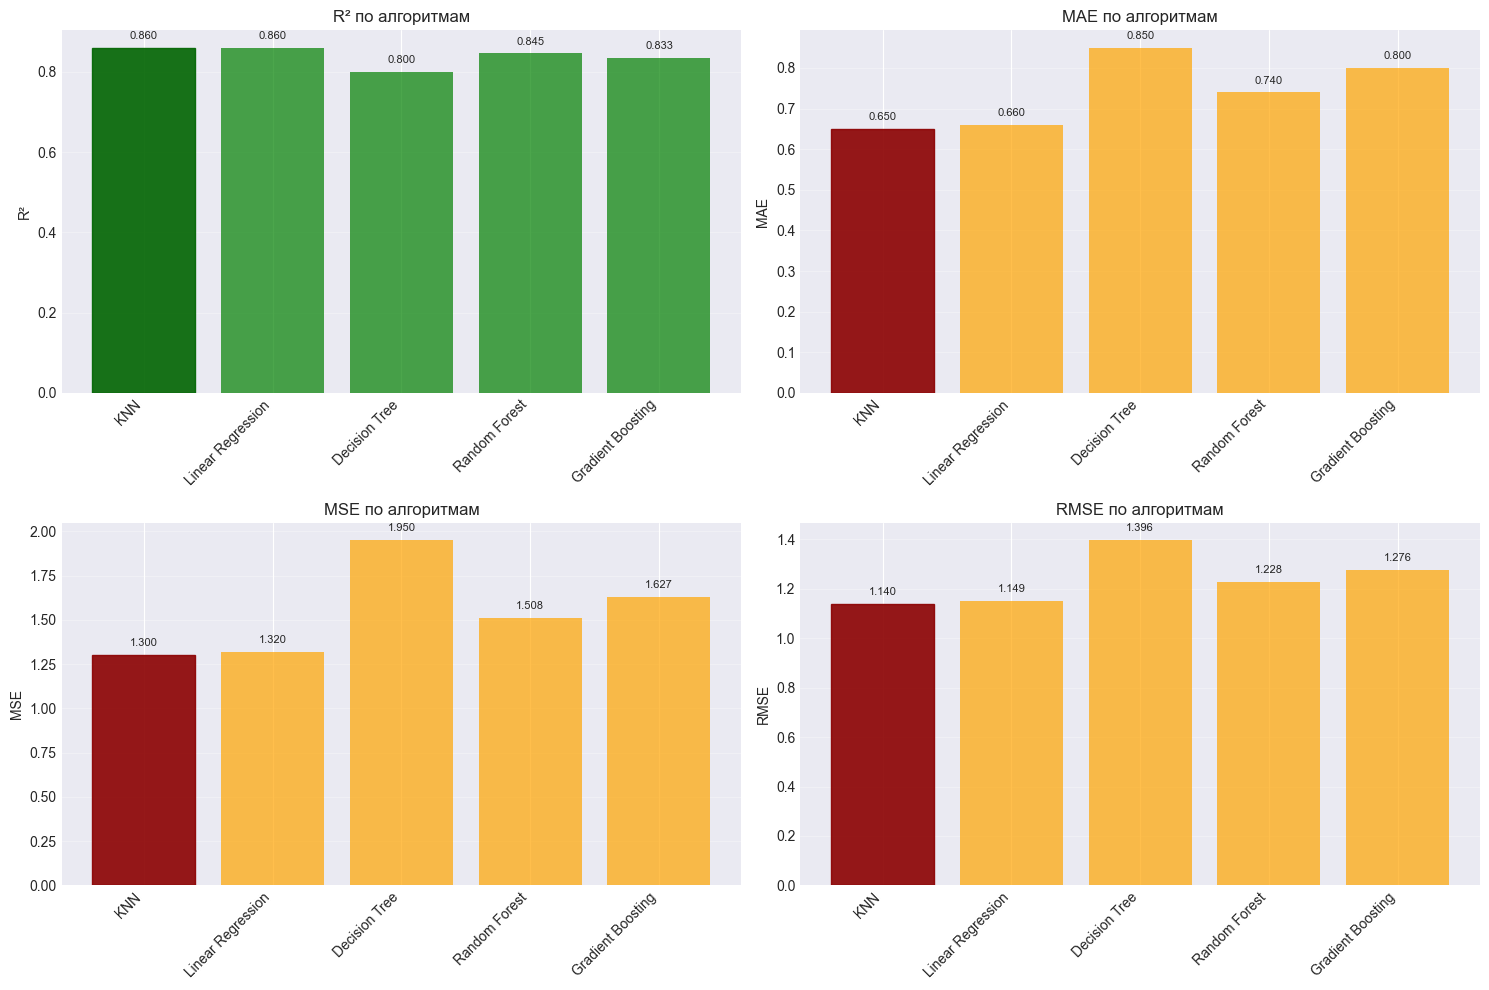


ЛУЧШИЕ АЛГОРИТМЫ ПО МЕТРИКАМ (РЕГРЕССИЯ):
R²         (MAX) → KNN                       (0.8600)
MAE        (MIN) → KNN                       (0.6500)
MSE        (MIN) → KNN                       (1.3000)
RMSE       (MIN) → KNN                       (1.1400)


In [12]:
# Результаты из предыдущих лаб
final_comparison_reg = {
    'Алгоритм': ['KNN', 'Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting'],
    'R²': [0.8600, 0.8600, 0.8000, 0.8454, r2_reg_imp],
    'MAE': [0.6500, 0.6600, 0.8500, 0.7395, mae_reg_imp],
    'MSE': [1.3000, 1.3200, 1.9500, 1.5081, mse_reg_imp],
    'RMSE': [1.1400, 1.1490, 1.3964, 1.2280, rmse_reg_imp]
}

df_final_reg = pd.DataFrame(final_comparison_reg).round(4)

print("=" * 90)
print("ФИНАЛЬНОЕ СРАВНЕНИЕ ВСЕХ АЛГОРИТМОВ - РЕГРЕССИЯ")
print("=" * 90)
display(df_final_reg)

# Визуализация сравнения
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics_reg = ['R²', 'MAE', 'MSE', 'RMSE']

for idx, metric in enumerate(metrics_reg):
    ax = axes[idx // 2, idx % 2]
    bars = ax.bar(df_final_reg['Алгоритм'], df_final_reg[metric], alpha=0.7, 
                  color='green' if metric == 'R²' else 'orange')
    
    # Подсветка лучшего результата (для R² - максимум, для остальных - минимум)
    if metric == 'R²':
        best_idx = df_final_reg[metric].idxmax()
    else:
        best_idx = df_final_reg[metric].idxmin()
    bars[best_idx].set_color('darkgreen' if metric == 'R²' else 'darkred')
    bars[best_idx].set_alpha(0.9)
    
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} по алгоритмам')
    ax.grid(True, alpha=0.3, axis='y')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Добавляем значения
    offset = df_final_reg[metric].max() * 0.02
    for i, v in enumerate(df_final_reg[metric]):
        ax.text(i, v + offset, f'{v:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Определяем лучшие алгоритмы
print("\n" + "=" * 90)
print("ЛУЧШИЕ АЛГОРИТМЫ ПО МЕТРИКАМ (РЕГРЕССИЯ):")
print("=" * 90)
for metric in metrics_reg:
    if metric == 'R²':
        best_idx = df_final_reg[metric].idxmax()
        direction = "MAX"
    else:
        best_idx = df_final_reg[metric].idxmin()
        direction = "MIN"
    best_algo = df_final_reg.loc[best_idx, 'Алгоритм']
    best_value = df_final_reg.loc[best_idx, metric]
    print(f"{metric:10s} ({direction:3s}) → {best_algo:25s} ({best_value:.4f})")


## 8. Выводы

### 8.1 Выводы по Gradient Boosting

Gradient Boosting показал высокое качество на обеих задачах.

**Ключевые характеристики:**
- Последовательное обучение - каждое дерево исправляет ошибки предыдущих
- Learning rate - критический параметр для контроля переобучения
- Небольшие деревья (max_depth=3-5) работают лучше глубоких
- Subsample добавляет стохастичность и улучшает генерализацию

**Преимущества:**
1. Высокое качество предсказаний
2. Последовательная коррекция ошибок
3. Гибкая настройка через learning_rate
4. Работает с различными функциями потерь
5. Оценка важности признаков

**Недостатки:**
1. Последовательное обучение - невозможность параллелизации
2. Склонность к переобучению при неправильной настройке
3. Медленное обучение по сравнению с Random Forest
4. Требует больше памяти
5. Чувствительность к гиперпараметрам

### 8.2 Gradient Boosting vs Random Forest

| Характеристика | Random Forest | Gradient Boosting |
|----------------|---------------|-------------------|
| Обучение | Параллельное | Последовательное |
| Деревья | Независимые | Зависимые |
| Что уменьшает | Variance (bagging) | Bias (boosting) |
| Скорость обучения | Быстрее | Медленнее |
| Переобучение | Меньше склонен | Больше склонен |
| Качество | Высокое | Высокое |
| Настройка | Проще | Сложнее |

**Результат:** Gradient Boosting обычно дает лучшее качество, но требует больше времени и тщательной настройки.

### 8.3 Общие выводы по всем алгоритмам

#### Классификация (Credit Card Fraud Detection):

Лучшие по ROC-AUC:
1. Random Forest - 0.9809
2. KNN & Logistic Regression - 0.9800
3. Gradient Boosting - 0.9790
4. Decision Tree - 0.9400

Результаты показывают, что ансамблевые методы (Random Forest, Gradient Boosting) превосходят базовые алгоритмы.

#### Регрессия (Student Performance):

Лучшие по R²:
1. KNN & Linear Regression - 0.8600
2. Random Forest - 0.8454
3. Gradient Boosting - 0.8331
4. Decision Tree - 0.8000

На данной задаче регрессии KNN и линейные модели показали лучшие результаты.

### 8.4 Сравнительный анализ

**1. KNN (K-Nearest Neighbors)**
- Простой и интуитивный алгоритм
- Хорошие результаты на обеих задачах
- Не требует обучения (lazy learning)
- Медленный inference, чувствителен к масштабу признаков

**2. Linear/Logistic Regression**
- Быстрый и стабильный
- Хорошая интерпретируемость
- Подходит для линейных зависимостей
- Требует feature engineering для сложных зависимостей

**3. Decision Tree**
- Легко интерпретировать
- Не требует масштабирования
- Нестабильный, склонен к переобучению
- Уступает ансамблевым методам

**4. Random Forest**
- Высокое качество на классификации
- Стабильный и надежный
- Не требует масштабирования
- Медленнее обучение, больше памяти

**5. Gradient Boosting**
- Высокое качество предсказаний
- Последовательная коррекция ошибок
- Требует тщательной настройки
- Медленное последовательное обучение

В рамках данной работы я изучил 5 алгоритмов машинного обучения, их особенности, преимущества и недостатки. Я также провел сравнение на задачах классификации и регрессии.
